In [2]:
!pip install pyaudio

     -------------------------------------- 164.1/164.1 kB 3.3 MB/s eta 0:00:00


In [5]:
import pyaudio
import wave
import os

# Set the sampling rate and duration of the recordings
sampling_rate = 44100
duration = 0.5  # in seconds

# Create a PyAudio object
audio = pyaudio.PyAudio()

# Define the letters and words to record
letters = ['a', 'b', 'c', 'd', 'e']
words = ['ad', 'be', 'cab', 'bad', 'ace', 'dab', 'bed', 'cad', 'cabbed', 'deed']

# Create directories to store the recordings
if not os.path.exists('recordings'):
    os.mkdir('recordings')

if not os.path.exists('recordings/letters'):
    os.mkdir('recordings/letters')

if not os.path.exists('recordings/words'):
    os.mkdir('recordings/words')

# Record the letters
for letter in letters:
    print(f"Recording letter {letter}...")
    stream = audio.open(format=pyaudio.paInt16, channels=1, rate=sampling_rate, input=True,
                        frames_per_buffer=int(sampling_rate * duration))
    frames = []
    for i in range(int(sampling_rate / int(sampling_rate * duration))):
        data = stream.read(int(sampling_rate * duration))
        frames.append(data)
    stream.stop_stream()
    stream.close()

    # Save the recording as a WAV file
    filename = f"recordings/letters/{letter}.wav"
    wf = wave.open(filename, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
    wf.setframerate(sampling_rate)
    wf.writeframes(b''.join(frames))
    wf.close()

print("Letters recorded successfully!")

# Record the words
for word in words:
    print(f"Recording word {word}...")
    stream = audio.open(format=pyaudio.paInt16, channels=1, rate=sampling_rate, input=True,
                        frames_per_buffer=int(sampling_rate * duration))
    frames = []
    for i in range(int(sampling_rate / int(sampling_rate * duration))):
        data = stream.read(int(sampling_rate * duration))
        frames.append(data)
    stream.stop_stream()
    stream.close()

    # Save the recording as a WAV file
    filename = f"recordings/words/{word}.wav"
    wf = wave.open(filename, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
    wf.setframerate(sampling_rate)
    wf.writeframes(b''.join(frames))
    wf.close()

print("Words recorded successfully!")


Recording letter a...
Recording letter b...
Recording letter c...
Recording letter d...
Recording letter e...
Letters recorded successfully!
Recording word ad...
Recording word be...
Recording word cab...
Recording word bad...
Recording word ace...
Recording word dab...
Recording word bed...
Recording word cad...
Recording word cabbed...
Recording word deed...
Words recorded successfully!


Epoch 1/50
2/2 [==============================] - 4s 798ms/step - loss: 2.8223 - accuracy: 0.0000e+00 - val_loss: 2.8972 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 122ms/step - loss: 2.5839 - accuracy: 0.1786 - val_loss: 3.0870 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 123ms/step - loss: 2.4647 - accuracy: 0.3571 - val_loss: 3.2223 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 121ms/step - loss: 2.3748 - accuracy: 0.1786 - val_loss: 3.3359 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 123ms/step - loss: 2.2967 - accuracy: 0.3571 - val_loss: 3.4244 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 0s 124ms/step - loss: 2.2266 - accuracy: 0.3571 - val_loss: 3.5095 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 0s 127ms/step - loss: 2.1655 - accuracy: 0.3571 - val_loss: 3.6269 - val_accuracy:

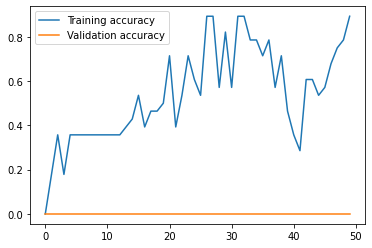

AttributeError: module 'matplotlib' has no attribute 'pyplot'

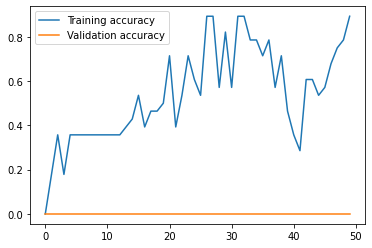

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [10]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical


# Define the alphabet and words
alphabet = ['a', 'b', 'c', 'd', 'e']
words = ['ad', 'be', 'cab', 'bad', 'ace', 'dab', 'bed', 'cad', 'cabbed', 'deed']


# Function to convert audio file to spectrogram
def get_spectrogram(audio_file):
    y, sr = librosa.load(audio_file, duration=0.5)  # Load the audio file
    spect = librosa.feature.melspectrogram(y=y, sr=sr)  # Generate spectrogram
    spect_db = librosa.power_to_db(spect, ref=np.max)  # Convert to dB scale
    return spect_db


# Load data and generate spectrograms
spectrograms = []
labels = []

for i, letter in enumerate(alphabet):
    for j in range(5):
        audio_file = f"recordings/letters/{letter}.wav"
        spectrogram = get_spectrogram(audio_file)
        spectrograms.append(spectrogram)
        labels.append(i)
        
        
for i, word in enumerate(words):
    audio_file = f"recordings/words/{word}.wav"
    spectrogram = get_spectrogram(audio_file)
    spectrograms.append(spectrogram)
    labels.append(i + len(alphabet))

spectrograms = np.array(spectrograms)
labels = np.array(labels)

# One-hot encode labels
labels = to_categorical(labels)

# Train-test split
split_idx = int(0.8 * len(spectrograms))
x_train, y_train = spectrograms[:split_idx], labels[:split_idx]
x_test, y_test = spectrograms[split_idx:], labels[split_idx:]

# Define the model
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(alphabet) + len(words), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=16)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()
